In [1]:
# https://keras.io/examples/nlp/text_classification_with_transformer/

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output, weights = self.att(inputs, inputs, return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), weights
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

print(x_train.shape)

x_train[:10]

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/lingfeng/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/lingfeng/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant t

25000 Training sequences
25000 Validation sequences
(25000, 200)


array([[   5,   25,  100, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [  42, 1134,    6, ...,   72,   33,   32],
       [5533,   15,    4, ...,   28,  126,  110],
       [   0,    0,    0, ...,    7,   43,   50]], dtype=int32)

In [3]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x, attention_scores = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val)
)

Epoch 1/2
782/782 [==============================] - 75s 95ms/step - loss: 0.5151 - accuracy: 0.7212 - val_loss: 0.3542 - val_accuracy: 0.8394
Epoch 2/2
782/782 [==============================] - 73s 94ms/step - loss: 0.1967 - accuracy: 0.9251 - val_loss: 0.3129 - val_accuracy: 0.8730


In [4]:
test_index = 0

test_case = x_val[test_index]
print("label:", y_val[test_index])

import numpy as np
print("prediction:", model.predict(np.expand_dims(test_case,axis=0)))

model.summary()

label: 0
prediction: [[0.9693406  0.03065939]]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
token_and_position_embedding (None, 200, 32)           646400    
_________________________________________________________________
transformer_block (Transform ((None, 200, 32), (None,  10656     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_3 (Dro

attention_score_results.shape: (1, 2, 200, 200)


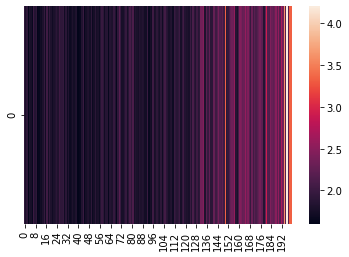

In [5]:
model_get_attention = keras.Model(inputs=model.inputs, outputs=model.get_layer("transformer_block").output[1])

attention_score_results = model_get_attention.predict(np.expand_dims(test_case,axis=0))

print("attention_score_results.shape:", attention_score_results.shape)

import seaborn as sns
import matplotlib.pylab as plt

attention_score_results_combine = attention_score_results[0][0] + attention_score_results[0][1] # two attention heads

attention_score_results_sum = np.sum(attention_score_results_combine,axis=0)

ax = sns.heatmap(np.expand_dims(attention_score_results_sum,axis=0))
plt.show()

In [6]:
word_index = keras.datasets.imdb.get_word_index()                                    
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])            
decoded_review = ' '.join([reverse_word_index.get(i - 3, "") for i in test_case])

print(decoded_review)

                                                                                                                                     please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss


In [8]:
import matplotlib

def colorize(words, color_array):
    cmap=matplotlib.cm.Blues
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
#         print(color)
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

words = decoded_review.split()

words_len = len(words)

attention_score_results_sum_cut = attention_score_results_sum[-words_len:]

attention_score_results_sum_cut = attention_score_results_sum_cut / np.amax(attention_score_results_sum_cut)

s = colorize(words, attention_score_results_sum_cut)

# or simply save in an html file and open in browser
with open('colorize.html', 'w') as f:
    f.write(s)